<a href="https://colab.research.google.com/github/nanom/llm_adaptation_workshop/blob/main/Taller_de_adaptaci%C3%B3n_de_modelos_de_lenguaje_abiertos_13_de_septiembre_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller de adaptación de modelos de lenguaje abiertos

¿Quiénes somos?
------------------

* Hernán Maina - Becario doctoral de CONICET
* Guido Ivetta - Becario doctoral de Vía Libre y Profesor Ayudante de FAMAF
* Laura Alonso Alemany - Profesora Asociada de FAMAF
* Luciana Benotti - Profesora Asociada de FAMAF

<div style="text-align:center">
 <h4 style="font-size:1.5em;margin:5px"></h4>
    <h5 style="font-style:normal;font-size:1em;margin:5px"></h5>
    <div style="display:inline-block;margin-right:0px;">
        <img src="https://vialibre.org.ar/wp-content/uploads/2020/10/banner-2.jpg" style="height:10em;width:auto;"/>
    </div>
    <h6 style="font-style:normal;font-size:0.9em;margin:5px;">
        <a href="https://twitter.com/" style="color:royalblue;" target="_blank">@fvialibre</a> -
        <a href="https://www.vialibre.org.ar/" style="color:royalblue;" target="_blank">https://www.vialibre.org.ar/</a>
    </h6>
    
</div>

## Esquema del taller

1. [Modelos de lenguaje](#Modelos-de-lenguaje)
2. [Librerias](#Librerias)
3. [Probemos modelos](#Probemos-modelos)
4. [Personalicemos un modelo](#Personalicemos-un-modelo)

*Requerimientos deseables para entender este taller:*
* Conocimiento básico de Python
* Conocimiento básico en entrenamiento de modelos

*Librerías principales utilizadas*:
* [🤗 HuggingFace](https://huggingface.co/)

*Agradecimientos*:
* **Cristian Cardellino**, por la inspiración en la estructura de partes del notebook. Ver [acá](https://colab.research.google.com/#fileId=https%3A//huggingface.co/crscardellino/xi-ciai-cba-martin-fierro/blob/main/xi-ciai-cba.ipynb) para más detalles.
* **Beatriz Busaniche**, **Nair Carolina** y **Alexia Halvorsen** de la Fundación Vía Libre por su continuo apoyo.
* **Matías Bordone** y **Librebase Córdoba**, por la organización de la jornada.
* **FAMAF**, por la apertura y predisposición.

# **IMPORTANTE**

Todas las celdas de código que comiencen con ❗son obligatorias y necesarias para el correcto funcionamiento de este taller.

Aquellas que comiencen con 🔎 son de profundización de contenido, son optativas de leer y computar.

Si una celda contiene el símbolo ⏳ significa que tomará más tiempo en computarse que el promedio. Tener en cuenta para aprovechar al máximo el tiempo disponible del taller.

# 0 - Inicialización de la notebook

In [ ]:
#❗
# @title
# Install libraries
!pip install -U transformers[torch] --quiet
!pip install -U tabulate --quiet
!pip install -U datasets --quiet

In [ ]:
#❗
# @title
# Download datasets
import os

ROOT_PATH = "llm_adaptation_workshop"
DATASETS_PATH = os.path.join(ROOT_PATH, "datasets")

%rm -r "$ROOT_PATH"
!git clone https://github.com/nanom/llm_adaptation_workshop.git "$ROOT_PATH"

rm: cannot remove 'llm_adaptation_workshop': No such file or directory
Cloning into 'llm_adaptation_workshop'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 6), reused 20 (delta 5), pack-reused 0
Receiving objects: 100% (32/32), 23.09 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
#❗
# @title
# GPU check
!nvidia-smi

# 1 - Modelos de lenguaje

## ¿Qué son los "modelos de lenguaje"?

- Son modelos estadísticos predictivos, basados en aprendizaje automático sobre textos.
- Su función principal es **analizar** y/o **generar** texto de manera automática.
- Se entrenan encontrando patrones en grandes cantidades de texto libre.
- Dado un contexto (e.g. una secuencia de palabras), aplican los patrones inferidos para predecir la palabra siguiente, generando texto plausible y coherente.
- Si bien los modelos de lenguaje existen desde hace varias décadas en diferentes formas (modelos markovianos, conditional random fields, redes neuronales recurrentes), actualmente cuando alguien habla de un "Modelo de Lenguaje", usualmente se refiere a un modelo neuronal de tipo **Transformer**.

### ¿Qué es un **Transformer**?

- Es un tipo de arquitectura de redes neuronales que se introdujo en el paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762).

- El tipo de aprendizaje que hacen estas redes está basado en **mecanismos de atención**, que ayudan al modelo a enfocarse en las partes más determinantes de la información, de forma que el entrenamiento sea más rápido y menos costoso que para otras arquitecturas, como las redes neuronales recurrentes.

<!-- La idea fundamental detras de un modelo Transformer, es procesar el lenguaje natural de una manera muy eficiente y efectiva, haciendolo ideal para ser aplicado a una gran cantidad de tareas de PLN.-->

- Existen diferentes variantes de transformer, de acuerdo a cómo y qué parte de sus componentes utilizan:
    - Los modelos de traducción secuencia a secuencia o `Seq2Seq` (e.g. [T5](https://arxiv.org/abs/1910.10683)), tienen un **codificador y decodificador** y son empleados para tareas de transformación como traducción, simplificación, cambio de estilo o resumen.
    - Los modelos que sólo usan el **codificador** (e.g. [BERT](https://arxiv.org/abs/1810.04805)) se usan para obtener representaciones vectoriales del texto (*embeddings*) que resultan muy útiles para  determinar relaciones de semejanza entre diferentes textos.
    - Los modelos basados en el **decodificador** (e.g. [GPT](https://arxiv.org/abs/2005.14165)) se usan para generar texto automáticamente, como respuestas a preguntas, ensayos o cuentos, entre otros.

<center><img src='https://heidloff.net/assets/img/2023/02/transformers.png' width=60%></center>

**Nota:** *Para una explicación más sencilla, pero más detallada, sugiero los posts de la serie "The Illustrated..." de [Jay Alammar](http://jalammar.github.io/):*
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [The Illustrated BERT](http://jalammar.github.io/illustrated-bert/)
- [The Illustrated GPT-2](http://jalammar.github.io/illustrated-gpt2/) / [How GPT-3 Works](http://jalammar.github.io/how-gpt3-works-visualizations-animations/)

## Probamos un BERT mediante la tarea *fill-mask*

En esta sección vamos a practicar con [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), un modelo de lenguaje con una arquitectura compuesta de **codificadores** (encoders).


Para familiarizarnos con BERT, vamos a jugar con la tarea "*Fill-Mask*", cuyo objetivo es completar una oración con algunas palabras, en los lugares marcados con `[MASK]`.

El modelo de lenguaje predecirá las palabras más adecuadas para encajar en esos espacios en blanco, es decir, las más probables dado el contexto, según los patrones estadísticos inferidos de los ejemplos de aprendizaje. Esto nos sirve para evaluar qué tan bien está modelando los textos.

In [ ]:
#🔎
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-uncased"

fillmask = pipeline(
    task="fill-mask",
    model=MODEL_CHECKPOINT,
    top_k=5
)

In [ ]:
#🔎
ejemplo = 'Córdoba es una [MASK] de Argentina.'
fillmask(ejemplo)

[{'score': 0.20739290118217468,
  'token': 20759,
  'token_str': 'ciudad',
  'sequence': 'cordoba es una ciudad de argentina.'},
 {'score': 0.1152777448296547,
  'token': 19891,
  'token_str': 'historia',
  'sequence': 'cordoba es una historia de argentina.'},
 {'score': 0.0633617490530014,
  'token': 19830,
  'token_str': 'vida',
  'sequence': 'cordoba es una vida de argentina.'},
 {'score': 0.054271843284368515,
  'token': 21137,
  'token_str': 'musica',
  'sequence': 'cordoba es una musica de argentina.'},
 {'score': 0.016035491600632668,
  'token': 16501,
  'token_str': 'universidad',
  'sequence': 'cordoba es una universidad de argentina.'}]

## Probamos un GPT para la tarea de generación de texto

En esta sección vamos a practicar con [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer), un modelo de lenguaje generativo con una arquitectura basada en transformers.

Vamos a jugar con la función de generación del modelo, que, dada una secuencia de palabras, predice la continuación más probable para la misma, según los patrones inferidos en los ejemplos de aprendizaje.

In [ ]:
#🔎
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

pipe = pipeline("text-generation", model="gpt2")

In [ ]:
#🔎
pipe("My name is Lewis and I like to")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'My name is Lewis and I like to talk about music. There\'s something about the way I\'m doing it and I want to show people how I create melodies. And I think people think I\'m pretty great. But maybe I\'m not."\n'}]

# 2 - Librerías para modelos de lenguaje


##  ¿Qué es Hugging Face 🤗?

- Una [comunidad colaborativa](https://huggingface.co/) especialmente enfocada en modelos de lenguaje y otros recursos de Inteligencia Artificial (IA).
- Ofrece repositorios para disponibilizar [modelos](https://huggingface.co/models), [datasets](https://huggingface.co/datasets) y [demos](https://huggingface.co/spaces).
- Además, ofrece varias librerías orientadas a la IA, particularmente al Aprendizaje Profundo (*Deep Learning*), entre las que destacan:
    - [`transformers`](https://huggingface.co/docs/transformers): La que veremos en esta charla, para todo lo relacionado a Procesamiento del Lenguaje Natural (PLN) con grandes modelos de lenguaje (*Large Language Models*, LLMs).
    - [`datasets`](https://huggingface.co/docs/datasets): Una librería con funcionalidades para el tratamiento de los conjuntos de datos a utilizar para entrenar o ajustar los LLMs.
    - [`tokenizers`](https://huggingface.co/docs/tokenizers): Una librería para el proceso de "tokenización", i.e. la división de texto de manera discreta en palabras o subpalabras.
- Hugging Face no sólo ofrece soluciones para PLN, sino también para imágenes, con librerías como [`diffusers`](https://huggingface.co/docs/diffusers), para la generación de imágenes:
    - Lectura recomendada: [The Illustrated Stable Diffusion](http://jalammar.github.io/illustrated-stable-diffusion/)

## ¿Cómo empezar con Hugging Face 🤗?

- Primero se [crea una cuenta en la página](https://huggingface.co/join).
- Luego podemos [crear modelos](https://huggingface.co/new) a través del menú que se despliega de nuestro avatar.
- Para poder subir tu modelo en tu cuenta de Hugging Face, primero necesitarás generar un token de acceso mediante los [Siguientes Pasos](https://huggingface.co/docs/hub/security-tokens)!

# 3 - ¿Cómo se entrenan los modelos de lenguaje?

En esta notebook **NO** vamos a entrenar completamente un LLM, porque los LLMs requieren de muchos datos y mucho cómputo para ser entrenados:
- Para **BERT**:
    - El costo total estimado de entrenamiento del modelo fue de U\$D 6912 (para su version *large*) y de U\$D 500 (para su versión *base*).
    - Mientras que la versión pequeña (*base*) cuenta con 109M de parámetros, su versión original (*large*) oscila en 334M, más del triple.
    - Su entrenamiento fue realizado sobre 3.3B de tokens (aproximadamente 20 GB de texto no comprimido).

- Para **GPT-3**:
    - Se estimó un costo de entrenamiento cercano a los U\$D 4.6 Millones.
    - Disponible en ocho tamaños, que van desde los 125M a los 175B parámetros.
    - Requirió de varias semanas de entrenamiento.
    - El corpus reportado en el cual fue entrenado es aproximadamente 500B de palabras.
    - Varios GPUS para entrenarlo y hardware especializado.

Sin embargo, vamos a **entrenar parcialmente** un modelo de lenguaje, en concreto, vamos a adaptarlo a un dominio particular.



## Diferencia entre pre-training y fine-tuning

La distinción clave entre pre-training y fine-tuning se encuentra en las etapas del proceso de entrenamiento:

* El **pre-training**, es la primera fase de entrenamiento al que se somete todo modelo LLM, y requiere de una enorme cantidad de textos genéricos, como se ha descrito en el apartado anterior.

* Una vez finalizado este proceso inicial de entrenamiento, se obtiene un modelo genérico capaz de realizar predicciones genéricas sobre patrones textuales, pero sin especialización en ninguna tareas específicas.

* Si deseamos adaptar este modelo genérico para que desempeñe una tarea específica con un alto rendimiento (e.g.: *Text Clasification*, *Sentiment analysis*, *Question Answering*, *Information Extraction*, etc.), se lleva a cabo una segunda etapa de entrenamiento conocida como **fine-tuning**.

<center>
<!-- <img src="https://serokell.io/files/7i/7iyrq1z5.Inside_ChatGPT_pic1.png" width=80%>-->
<img src="https://miro.medium.com/v2/resize:fit:951/0*R31A71UjHM8R8Pps.png" width=80%>
</center>
<right> fuente: https://medium.com/mantisnlp/supervised-fine-tuning-customizing-llms-a2c1edbf22c3
</right>

Este entrenamiento específico requiere de menos ejemplos de entrenamiento y menos cálculo, ya que sólo modifica ligeramente el modelo ya entrenado. En este proceso, existen varías formas en como se "modifica" el modelo pre-entrenado durante esta fase: se pueden modificar las últimas capas, añadir capas a la red pre-entrenada, y otras variantes. En esta notebook vamos a trabajar con una aproximación sencilla, pero existen múltiples librerías en Huggingface que implementan funcionalidades para llevar adelante difrentes tipos de *fine-tuning*, como por ejemplo la popular [LoRA](https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms).

<!--<center>
<img src="https://media.licdn.com/dms/image/D5612AQEe2e_DJ51f2g/article-inline_image-shrink_1000_1488/0/1687324002269?e=1699488000&v=beta&t=vWDbM2RYNKa9tv5--w6Iub7YRRGkjld-s7U6VDd_7_Q" width=80%>

</center>
<right> fuente: https://www.linkedin.com/pulse/beginners-guide-fine-tuning-large-language-models-vaidheeswaran
</right>-->

## *Domain Adaptation*

Mientras que *fine-tuning* se centra en ajustar un modelo de lenguaje *pre-entrenado* para realizar tareas específicas, la adaptación de dominio se enfoca en hacer que el modelo sea más efectivo en un dominio de datos particular.

En caso de que tus datos de entrenamiento pertenezcan a un determinado tema específico (e.g.: leyes, medicina, informática, etc.) o un estilo específico (e.g.: académico, infantil, publicitario, etc.), y difieran substancialmente del corpus estándar en el cual fue entrenado inicialmente el LLM, podemos pensar diferentes opciones para incorparar este nuevo conocimiento:


1. **Entrenamiento desde cero:** Este enfoque implica entrenar desde cero (*from scratch*) un nuevo modelo de lenguaje con textos del dominio de interés. Sin embargo, no es recomendable para el público en general, dada la gran cantidad de recursos computacionales, horas de procesamiento y textos de entrenamiento necesarios para lograr un rendimiento comparable a los modelos estado del arte (modelos *state-of-the-art, SOTA*).
2.  **Uso de modelos disponibles:** Se aprovechan modelos disponibles públicamente, específicos para el dominio de interés (e.g: [LegalBERT](https://arxiv.org/abs/2010.02559), [FinBERT](https://arxiv.org/abs/1908.10063) y [BioBERT](https://arxiv.org/abs/1901.08746); todos disponibles en Hugging Face 🤗 de manera gratuita.)
3. **Adaptación de modelos pre-entrenados**: Esta aproximación, tambien conocida en la literatura como *'further pre-training'*, *'inter-training'*, *'continued pre-training'* o *'domain-adaptation'*, implica tomar un modelo de lenguaje pre-entrenado para un dominio cualquiera y, aprovechando todo el conocimiento y las representaciones ya aprendidas, **continuar su entrenamiento sobre el conjunto de datos especializados o personalizados**. Esta técnica permite alcanzar muy buenos resultados, utilizando menos recursos computacionales, horas y datos de entrenamiento.

<center>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*4eNaH6y0dSsaxtTQW0tgHQ.png" width=80%>
</center>
<right> fuente: https://medium.com/@shankar.arunp/training-bert-from-scratch-on-your-custom-domain-data-a-step-by-step-guide-with-amazon-25fcbee4316a
</right>

# 4 - Vamos a personalizar un modelo!

## 4.1 - ¿Cómo personalizar un modelo BERT?


Tanto para el entrenamiento inicial (*pre-training*) como para la adaptación de dominio mediante un entrenamiento intermedio (*inter-training*), el modelo debe ser re-entrenado utilizando tareas auto-supervisadas, ya sea la tarea de **Masked Language Modeling (MLM)**, o una combinación entre **(MLM)** y **Next Sentence Prediction (NSP)**.

### Masked Language Modeling (MLM)
> Consiste en enmascarar (ocultar) palabras aleatorias en cada oración o frase de entrada, y entrenar el modelo para que aprenda a predecirlas basándose en el contexto circundante (palabras vecinas). Durante el entrenamiento, alrededor del **15%** de las palabras se seleccionan al azar y se enmascaran, reemplazándolas con el token especial **[MASK]**. De esta forma, el modelo infiere patrones de relaciones entre palabras.
<center>
<img src="http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png" width=80%>
</center>

### Next Sentence Prediction (NSP)
> Aunque no obligatorio, es otro componente importante en el entrenamiento de BERT. A partir de un texto considerado como una secuencia de oraciones, se generan ejemplos de entrenamiento consistentes en pares de oraciones aleatorios. El modelo tiene que aprender a identificar si una oración sigue a otra en el texto original. De esta forma, el modelo infiere patrones de relaciones entre oraciones.

<center>
<img src="http://jalammar.github.io/images/bert-next-sentence-prediction.png" width=80%>
</center>

En esta notebook **realizaremos el ajuste de dominio mediante la tarea de MLM** utilizando la clase [**BertForMaskedLM**](https://huggingface.co/docs/transformers/v4.32.1/en/model_doc/bert#transformers.BertForMaskedLM) (modelo BERT con un bloque superior extra que posibilita el `modelado del lenguaje enmascarado`), ofrecida por biblioteca de [**transformer**](https://github.com/huggingface/transformers) de HuggingFace 🤗.

* Se utilizarán diferentes datasets especializados (tanto en español como en inglés).
* Utilizaremos como modelo pre-entrenado  [bert-base-uncased](https://huggingface.co/bert-base-uncased) para realizar la adaptación en los datasets en inglés, y [dccuchile/bert-base-spanish-wwm-uncased](https://huggingface.co/dccuchile/bert-base-spanish-wwm-uncased) para los correspondientes en español.


### Carga de datasets

* Utilizaremos la librería `datasets` de HuggingFace para cargar cada uno de los corpus seleccionados.
* Para la personalización de BERT, tenemos un total de 4 conjuntos de datos, 3 de ellos en español y 1 en Inglés:
    * Peppa Pig (es):
      * ≈ 3k oraciones.
      * Extraído de subtítulos de 77 episodios.
    * Martin Fierro (es):
      * ≈ 2k oraciones.
      * Extraído del libro completo de José Hernández
    * Preguntas de no videntes (en):
      * ≈ 33k oraciones.
      * Generado a partir de preguntas sobre objetos en imágenes por personas con discapacidades visuales.
    * Reseñas de Vinos (es):
      * ≈ 130k oraciones.
      * Extraído de descripciones de vinos de todo el mundo.
* A continuación, seleccionen de la lista desplegable el dataset que mas nos interese.
* En `max_samples`, elijan un límite máximo de datos para acotar el cómputo necesario.
* Automáticamente el siguiente código dividirá el dataset elegido en dos partes:
    * El 80% como conjunto de entrenamiento.
    * El 20% como conjunto de test.


In [ ]:
#❗
# @title  { run: "auto" }
import os
import torch
from datasets import load_dataset, Dataset

# To ensure determinism
torch.manual_seed(42)

# Form parameters
DATASET_NAME = "Peppa Pig (es)" # @param ["Referencias de Vinos (es)", "Preguntas de no videntes (en)", "Martin Fierro (es)", "Peppa Pig (es)"]
max_samples = 30000 # @param {type:"number"}
name_to_file = {
    'Preguntas de no videntes (en)' : "vizwiz.csv",
    'Referencias de Vinos (es)'     : "wines_es.csv",
    'Martin Fierro (es)'            : "martin_fierro.csv",
    'Peppa Pig (es)'                : "peppa_pig.csv",
}

# Load local dataset
bert_ds = load_dataset(
    path=DATASETS_PATH,
    data_files={'all_data': name_to_file[DATASET_NAME]},
)

# Split dataset into train and validation sets
total_size = min(max_samples, len(bert_ds['all_data']))
val_size = int(total_size *.2)
train_size = total_size - val_size

bert_ds = bert_ds["all_data"].train_test_split(
    train_size=train_size,
    test_size=val_size,
    seed=42
)

print(f"* Información del dataset '{DATASET_NAME}':\n---")
bert_ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating all_data split: 0 examples [00:00, ? examples/s]

* Información del dataset 'Peppa Pig (es)':
---


DatasetDict({
    train: Dataset({
        features: ['samples'],
        num_rows: 2235
    })
    test: Dataset({
        features: ['samples'],
        num_rows: 558
    })
})

In [ ]:
#🔎
# Ver los primeros 15 textos del dataset
for sample in bert_ds['train']['samples'][:15]:
    print(f">> {sample}")

>> Peppa, ¿seguro que no quieres quitarte los zapatos?
>> por muy rápido que corráis.
>> Hola mis chiquitines.
>> ¡No tiene gracia!
>> No te preocupes Peppa, soy un experto en montar tiendas.
>> ¡Oh, es un vestido, y es precioso!
>> ¡Y yo!
>> No pasa nada, esos estaban ya un poco viejos.
>> Papá Pig vuela la cometa.
>> La tita Pig ha traído a Cloe para que pase el día en casa de Peppa. 
>> George, ¡Vamos a disfrazarnos y a hacer (como) que somos papá y mamá.
>> ¡Castillo del viento allá vamos!
>> !Soy una mariposa! ¡soy una mariposa!
>> Sí, pobre Tedy. Vamos a secarlo.
>> Voy a mover mi varita mágica… 


### Tokenización de datos


- La tokenización es un paso de pre-procesamiento esencial cuando se utiliza BERT u otro LLM.
- BERT procesa el texto en forma de tokens, que son elementos individuales del texto de entrada, como palabras, signos de puntuación o tokens especiales como **[CLS]**, **[SEP]** , **[PAD]** , **[UNK]** , etc.
- Recuerde utilizar el modelo `bert-base-uncased` como modelo base para los datasets en idioma inglés, y `dccuchile/bert-base-spanish-wwm-uncased` para los datasets en español.

In [ ]:
#❗
# Iniciación de tokenizador
from transformers import BertTokenizer

MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-uncased" # @param ["bert-base-uncased","dccuchile/bert-base-spanish-wwm-uncased"]
tokenizer = BertTokenizer.from_pretrained(MODEL_CHECKPOINT, TOKENIZERS_PARALLELISM=False)

In [ ]:
#🔎
# Tokenización de ejemplo de prueba
samples = bert_ds['train']['samples'][:5]

for ith, sample in enumerate(samples):
    token_ids = tokenizer(sample)['input_ids']
    token_str = [tokenizer.decode([tk_id]) for tk_id in token_ids]
    print(f"{sample}")
    print(f"{token_str}\n")

Peppa, ¿seguro que no quieres quitarte los zapatos?
['[CLS]', 'pep', '##pa', ',', '¿', 'seguro', 'que', 'no', 'quieres', 'quitarte', 'los', 'zapatos', '?', '[SEP]']

por muy rápido que corráis.
['[CLS]', 'por', 'muy', 'rápido', 'que', 'corr', '##áis', '.', '[SEP]']

Hola mis chiquitines.
['[CLS]', 'hola', 'mis', 'chi', '##qui', '##tines', '.', '[SEP]']

¡No tiene gracia!
['[CLS]', '¡', 'no', 'tiene', 'gracia', '!', '[SEP]']

No te preocupes Peppa, soy un experto en montar tiendas.
['[CLS]', 'no', 'te', 'preocupes', 'pep', '##pa', ',', 'soy', 'un', 'experto', 'en', 'montar', 'tiendas', '.', '[SEP]']



In [ ]:
#🔎
# Ver los 'tokes especiales' utilizados por el Tokenizador
for name, tk in tokenizer.special_tokens_map.items():
    print(f"{name}. Token: {tk}; Token_id: {tokenizer.vocab[tk]}")

unk_token. Token: [UNK]; Token_id: 3
sep_token. Token: [SEP]; Token_id: 5
pad_token. Token: [PAD]; Token_id: 1
cls_token. Token: [CLS]; Token_id: 4
mask_token. Token: [MASK]; Token_id: 0


* Dado que entrenaremos un modelo de BERT con un conjunto de datos que tienen una longitud variable, es fundamental aplicar el proceso de tokenización y el relleno (padding) adecuados a nuestros datos. Esto permite que todas las secuencias tengan la misma longitud fija, garantizando un procesamiento uniforme y eficiente de los datos durante el entrenamiento y la inferencia.
* A continuación realizaremos un histograma de la cantidad de tokens de cada ejemplo, y utilizaremos esa información para realizar posteriormente la tokenización del dataset completo.

Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

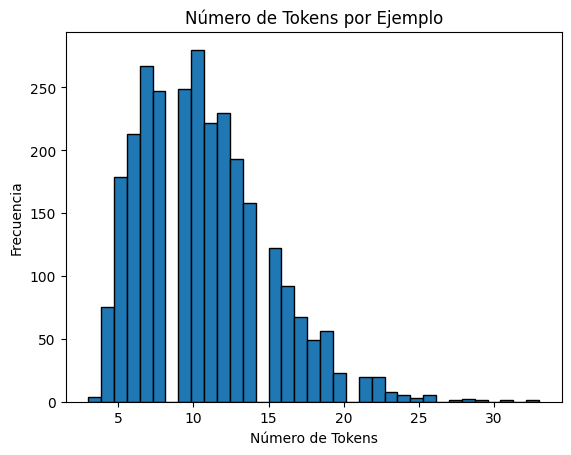

Total de ejemplos: 2793
Percentil 25: 7.0
Percentil 50 (Mediana): 10.0
Percentile 75: 13.0
Max: 33


In [ ]:
#❗
# Generación de histograma del número de tokens por ejemplos
import matplotlib.pyplot as plt
import numpy as np

# Calcular el número de tokens por ejemplos
def count_tokens_fn(batch):
    tokenized_batch = tokenizer(batch['samples'])
    tokenized_batch['count'] = [len(tks) for tks in tokenized_batch['input_ids']]
    return tokenized_batch

result = bert_ds.map(
    function=count_tokens_fn,
    batched=True
)

num_of_tokens_list = result['train']['count'] + result['test']['count']

# Graficar histograma
plt.hist(num_of_tokens_list, bins=35, edgecolor='k')
plt.xlabel('Número de Tokens')
plt.ylabel('Frecuencia')
plt.title('Número de Tokens por Ejemplo')
plt.show()

# Calcular percentiles (e.g., 25th, 50th, and 75th percentiles)
percentiles = np.percentile(num_of_tokens_list, [25, 50, 75])

print(f"Total de ejemplos: {len(num_of_tokens_list)}")
print(f"Percentil 25: {percentiles[0]}")
print(f"Percentil 50 (Mediana): {percentiles[1]}")
print(f"Percentile 75: {percentiles[2]}")
print(f"Max: {np.max(num_of_tokens_list)}")

- La función auxiliar `tokenize_data_fn` servirá para tokenizar y codificar el conjunto completo de datos de manera eficiente mediante el [método `map`](https://huggingface.co/docs/datasets/about_map_batch).
- Lo que devuelve es un nuevo dataset cuyos tokens estarán convertidos en:
    - índices del vocabulario (*input_ids*),
    - mascaras de atención [(*attention_mask*)](https://huggingface.co/docs/transformers/glossary#attention-mask),
    - tipos de tokens [(*token_type_ids*)](https://huggingface.co/docs/transformers/glossary#token-type-ids),
    - y etiquetas (*labels*), los cuales serán untilizados como `Ground True` en la etapa de entrenamiento.
- `MAX_TOKEN_LENGTH`: Indica el máximo número de tokens a utilizar por data. Debemos aumentarlo cuando nuestros conjuntos de datos son más largos. Una estrategia común es realizar un histograma y quedarnos con el valor del percentil 75% del largo de nuestros datos. También podemos utilizar el número de tokens de la seccuencia mas larga si se dispone de capacidad de cómputo suficiente.

In [ ]:
#❗
# Tokenicación de conjunto de datos completo

# Número máximo de tokens a utilizar
MAX_TOKEN_LENGTH = 33 # @param {type:"number"}

def tokenize_data_fn(batch):
    tokenized_sample = tokenizer(
        batch['samples'],
        max_length=MAX_TOKEN_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )

    tokenized_sample["labels"] = tokenized_sample['input_ids'].clone()
    return tokenized_sample

tokenized_bert_ds = bert_ds.map(
    function=tokenize_data_fn,
    batched=True,
    remove_columns=["samples"]
)

print(tokenized_bert_ds)

Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2235
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 558
    })
})


In [ ]:
#🔎
# Ver resultado de proceso de tokenización para el primer ejemplo del conjunto de datos
sample = tokenized_bert_ds["train"][0]

print(f"- input_ids:        {sample['input_ids']}")
print(f"- attention_mask:   {sample['attention_mask']}")
print(f"- token_type_ids:   {sample['token_type_ids']}")
print(f"- labels:           {sample['labels']}")

- input_ids:        [4, 20842, 1280, 1019, 1063, 2165, 1041, 1054, 1803, 25428, 1067, 7566, 1059, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
- attention_mask:   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- token_type_ids:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- labels:           [4, 20842, 1280, 1019, 1063, 2165, 1041, 1054, 1803, 25428, 1067, 7566, 1059, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Enmascarado Aleatorio

> Este método se encarga de realizar el enmascaramiento aleatorio y formatear los datos de entrenamiento de manera adecuada, asegurando que las secuencias de entrada tengan la longitud correcta y que las máscaras de atención se apliquen correctamente.

* Para implementar este proceso de manera sencilla, utilizaremos el método [DataCollatorForLanguageModeling](https://huggingface.co/docs/transformers/v4.32.1/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling) proporcionado por la biblioteca HuggingFace.

* Como se podrá observar en el siguente ejemplo, es común utilizar un valor especial como **-100** en la salida de las etiquetas (*labels*) para indicar la posición de los tokens que se **IGNORAN** en el cálculo de la función de pérdida llevada a cabo durante el entrenamiento.

In [ ]:
#❗
import torch, random
from transformers import DataCollatorForLanguageModeling

data_collate_fn = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15
)

In [ ]:
#🔎
# Visualizacion de proceso de 'Enmascarado Aleatorio' de tokens
seed = random.randint(0,100)
samples = [tokenized_bert_ds['train'][i] for i in range(3)]

print("DataCollator Outputs")
torch.manual_seed(seed)
print("--- Tokens:")
for sample in data_collate_fn(samples)['input_ids']:
    print(f">> {[tokenizer.decode([tk]) for tk in sample]}'")

torch.manual_seed(seed)
print("\n--- 'input_ids':")
for sample in data_collate_fn(samples)['input_ids']:
    print(f">> {sample.tolist()}'")

torch.manual_seed(seed)
print("\n--- 'labels':")
for sample in data_collate_fn(samples)['labels']:
    print(f">> {sample.tolist()}")

DataCollator Outputs
--- Tokens:
>> ['[CLS]', '[MASK]', '##pa', '[MASK]', '¿', '[MASK]', 'que', 'no', 'quieres', 'quitarte', 'los', 'zapatos', '[MASK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']'
>> ['[CLS]', '[MASK]', 'muy', 'rápido', '[MASK]', 'corr', '##áis', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']'
>> ['[CLS]', '[MASK]', 'mis', 'chi', '##qui', '##tines', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']'

--- 'input_ids':
>> [4, 0, 1280, 0, 1063, 0, 1041, 1054, 1803, 25428, 

### Probando el Modelo Base

- Antes de ajustar el modelo a nuestro conjunto de datos seleccionados, veremos cómo se desenvuelve en la tarea de *fill-mask* **antes de la personalización**.

- Para ello, escriba una frase muy característica del dominio al que se quiere adaptar, y enmascare alguna de sus palabras utilizando el token `[MASK]`.


In [ ]:
#🔎
# Ejemplo para español, pensando en adaptar el modelo a Peppa Pig
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

fillmask = pipeline(
    task="fill-mask",
    model="dccuchile/bert-base-spanish-wwm-uncased",
    top_k=5
)

ejemplo = 'A Peppa le encanta saltar en los [MASK] de barro'
fillmask(ejemplo)

[{'score': 0.22510451078414917,
  'token': 12837,
  'token_str': 'lagos',
  'sequence': 'a peppa le encanta saltar en los lagos de barro'},
 {'score': 0.1140349954366684,
  'token': 4473,
  'token_str': 'juegos',
  'sequence': 'a peppa le encanta saltar en los juegos de barro'},
 {'score': 0.10608550161123276,
  'token': 16441,
  'token_str': 'puentes',
  'sequence': 'a peppa le encanta saltar en los puentes de barro'},
 {'score': 0.08923324942588806,
  'token': 24094,
  'token_str': 'castillos',
  'sequence': 'a peppa le encanta saltar en los castillos de barro'},
 {'score': 0.04171948507428169,
  'token': 13452,
  'token_str': 'muros',
  'sequence': 'a peppa le encanta saltar en los muros de barro'}]

In [ ]:
#🔎
# Ejemplo para inglés, pensando en adaptar el modelo a VizWiz
# Usamos pipeline como función auxiliar de alto nivel
from transformers import pipeline

fillmask = pipeline(
    task="fill-mask",
    model="bert-base-uncased",
    top_k=5
)

ejemplo = "Can you [MASK] me the model on the back of the iPhone?"
fillmask(ejemplo)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.7363674640655518,
  'token': 2265,
  'token_str': 'show',
  'sequence': 'can you show me the model on the back of the iphone?'},
 {'score': 0.10993487387895584,
  'token': 2425,
  'token_str': 'tell',
  'sequence': 'can you tell me the model on the back of the iphone?'},
 {'score': 0.07615844905376434,
  'token': 2507,
  'token_str': 'give',
  'sequence': 'can you give me the model on the back of the iphone?'},
 {'score': 0.010204036720097065,
  'token': 2131,
  'token_str': 'get',
  'sequence': 'can you get me the model on the back of the iphone?'},
 {'score': 0.009682164527475834,
  'token': 4604,
  'token_str': 'send',
  'sequence': 'can you send me the model on the back of the iphone?'}]

### Entrenamiento para adaptación

- Una vez definido el conjunto de datos, pasamos a la parte más intensa computacionalmente, el entrenamiento.
- Podemos decidir guardar el modelo localmente o hacer un backup de cada época del modelo en Hugging Face.
- Definimos las propiedades del entrenamiento mediante [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments).
- Definimos el entrenamiento del modelo mediante [`Trainer`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer).
    
> <u>Detalles de parámetros a configurar</u>:
1.   ***epochs***: cantidad de epochs (una epoch es una pasada completa del dataset para el algoritmo de entrenamiento)
2.  ***batch_size***: Cantidad de datos procesados por iteración antes de actualizar el modelo (aumentar este número mejora las estimaciones de cada iteración ya que será una muestra más representativa del dataset en general, pero requerirá más memoria)
3.  ***learning_rate***: el tamaño de salto en la actualización del modelo en cada iteración.

**Nota**: El valor de estos parámetros determinará la cantidad de cálculo requerida para el entrenamiento tardará, que puede ir desde unos segundos hasta varios minutos, dependiendo de los parámetros configurados y el poder de cómputo disponible.


In [ ]:
#❗
from transformers import TrainingArguments, Trainer, BertForMaskedLM

# Delete old checkpoits folder
!rm -r "$CUSTOM_MODEL_CHECKPOINT"

# Set hiperparameters
MODEL_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-uncased" # @param ["dccuchile/bert-base-spanish-wwm-uncased", "bert-base-uncased"]
BATCH_SIZE = 64 # @param {type:"slider", min:8, max:64, step:8}
LEARNING_RATE = 2e-5 # @param {type:"number"}
EPOCHS = 5 # @param {type:"slider", min:3, max:15, step:1}
LOGGING_STEPS = len(tokenized_bert_ds["train"]) // BATCH_SIZE
CUSTOM_MODEL_CHECKPOINT = "bert_adaptation_" + DATASET_NAME.replace(" ", "_")

# Set training argumnets
training_args = TrainingArguments(
    output_dir=CUSTOM_MODEL_CHECKPOINT,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    num_train_epochs=EPOCHS,
    optim='adamw_torch',
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    push_to_hub=False,
    fp16=True,
    logging_steps=LOGGING_STEPS,
    report_to="none",
    save_strategy="no"
)

# Instance model and trainer method
model = BertForMaskedLM.from_pretrained(MODEL_CHECKPOINT)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_bert_ds["train"],
    eval_dataset=tokenized_bert_ds["test"],
    data_collator=data_collate_fn,
    tokenizer=tokenizer,
)

rm: cannot remove '': No such file or directory


* Antes de comenzar el entrenamiento calcularemos la [**Perplexity**](https://huggingface.co/docs/transformers/perplexity) del modelo de lenguaje.

> La `Perplexity` es una métrica que nos permite evaluar cuánta incertidumbre tiene un modelo cuando tiene que predecir palabras en un conjunto de prueba determinado. La misma, ayuda a medir qué tan bien conoce el modelo el lenguaje, y cuán coherentes serán sus predicciones. En general, una perplejidad más baja indicará que el modelo genera textos que claramente pertenecen al lenguaje.
<center>
<img src="https://thegradient.pub/content/images/size/w1600/2020/04/xkcd_entropy-2.png" width=50%>
</center>
fuente: https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

Si queremos evaluar qué tanto se adapta un modelo a un dominio determinado, podemos ver la perplejidad que tiene el modelo para las tareas de completar palabras (MLM) o generación de texto en oraciones del dominio de interés, ya sea un conjunto de oraciones que nos interesen particularmente (un *benchmark* o *testbed*) o un corpus representativo del dominio en general.

* Luego del entrenamiento de adaptación, compararemos los resultados de perplexity obtenidos después y antes de la adaptación.

In [ ]:
#🔎
import math

# fijamos la semilla para que los resultados sean reproducibles
torch.manual_seed(42)

# Estimate perplexity
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 168.20


In [ ]:
#❗⏳
# Train model
trainer.train()

# Save custom model locally
trainer.save_model(CUSTOM_MODEL_CHECKPOINT)

Epoch,Training Loss,Validation Loss
1,3.974000,3.259077
2,2.852400,2.825878
3,2.540200,2.674152
4,2.433300,2.339265
5,2.352900,2.252838


In [ ]:
#🔎
# To ensure determinism
torch.manual_seed(42)

# Estimate perplexity
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 11.88



### Probando el Modelo Adaptado

- Ahora que tenemos el modelo entrenado con el dataset específico, la pregunta es, ¿Cómo se comportará?
- Para ello volvemos a hacer la prueba anterior utilizando la tarea de *fill-mask*, quizás esta vez con mejores resultados.
- Para que los resultados sean mas fáciles de comparar, la función `compare_models()` será la encargada de procesar y retornar, para cada frase de ejemplo ingresada, un ranking comparativo de las predicciones realizadas entre el nuevo modelo adaptado y el modelo base original.

In [ ]:
#❗
import os
import transformers
from typing import List
from tabulate import tabulate
from transformers import pipeline

def compare_models(
    custom_model: transformers.pipelines.fill_mask.FillMaskPipeline,
    base_model: transformers.pipelines.fill_mask.FillMaskPipeline,
    sentences: List[str],
    top_k=5
) -> None:

    # Create compare table
    headers = ['Sent','Custom Bert', '(%)', 'Base Bert', '(%)']
    rows = []
    for sent in sentences:
        rows.append([sent, '', '', '', ''])

        c_out = custom_model(sent)
        o_out = base_model(sent)

        c_tokens = [(i['token_str'], str(round(i['score']*100,1))+"%") for i in c_out]
        o_tokens = [(i['token_str'], str(round(i['score']*100,1))+"%") for i in o_out]

        for (p1,s1), (p2,s2) in zip(c_tokens, o_tokens):
            rows.append(['', p1, s1, p2, s2])

    table = tabulate(rows, headers=headers, tablefmt="text", numalign="center")
    print(table, "\n")


# Instance models
base_model = pipeline(task="fill-mask", model=MODEL_CHECKPOINT)
custom_model = pipeline(task="fill-mask", model=CUSTOM_MODEL_CHECKPOINT)

In [ ]:
#❗
vizwiz_test_examples = [
    "can you tell me the title of the book? [MASK].",
    "please [MASK] this shirt",
    "what [MASK] is this?",
    "[MASK] can you tell me what is this?",
    "how clear is this [MASK]?",
    "is the floor [MASK]?",
    "the microwave is [MASK]?."
]

wines_test_examples = [
    "Este [MASK] argentino de altura es una verdadera",
    "Con un color profundo e [MASK]",
    "Los sabores de [MASK] persisten",
    "Hecho 100% de [MASK]",
    "El sabor fue [MASK]",
    "Con su [MASK] mezcla de minerales",
    "Por primera vez en [MASK],",
    "Brazamora de [MASK] bonito"
]

martin_fierro_test_examples = [
    "En los campos de la [MASK] extensa",
    "donde el viento y el sol se [MASK]",
    "cabalgo firme con mi [MASK]",
    "bajo el cielo de [MASK] risueño",

    "Con mi [MASK] y mi lazo",
    "enfrento a la [MASK] con valor",
    "batiéndome siempre a mi [MASK]",
    "en este ancho y rudo [MASK]",

    "Así cabalgo con alma [MASK]",
    "como otros en su [MASK]",
    "defendiendo mi [MASK] y mi gente",
    "en esta tierra que [MASK] sin cesar",

    "Con [MASK] al cinto, firme y diestro",
    "Enfrento [MASK], firme como el resto",
    "Mate en mano, bajo el cielo [MASK]",
    "Mi coraje y mi [MASK], jamás han claudicado."
]

peppa_pig_test_examples = [
    "[MASK], puedes decir dinosarurio?",
    "¡Hola, soy Peppa [MASK]!",
    "Hoy es un día [MASK] para un picnic.",
    "George tiene un [MASK] muy querido.",
    "El sol brilla en el [MASK] del jardín.",
    "Peppa y George juegan en el [MASK].",
    "Mamá Pig prepara [MASK] deliciosos.",
    "Vamos al [MASK] para montar en bicicleta.",
    "El [MASK] está lleno de flores hermosas.",
    "Peppa y sus amigos tienen [MASK] en el parque."
]

compare_models(
    custom_model=custom_model,
    base_model=base_model,
    sentences=peppa_pig_test_examples
)

Sent                                            Custom Bert    (%)    Base Bert    (%)
----------------------------------------------  -------------  -----  -----------  -----
[MASK], puedes decir dinosarurio?
                                                george         24.1%  uh           10.4%
                                                papi           8.4%   si           7.6%
                                                mami           6.5%   oh           6.3%
                                                ¿              4.5%   espera       6.3%
                                                mamá           2.7%   um           5.9%
¡Hola, soy Peppa [MASK]!
                                                pig            78.2%  [UNK]        5.1%
                                                mamá           3.5%   pep          3.6%
                                                /              1.8%   !            3.1%
                                                george      

### Subi tu modelo a Hugging Face  🤗

> Para poder subir tu modelo en tu cuenta en Hugging Face, primero necesitarás generar un token de acceso mediante los [Siguientes Pasos](https://huggingface.co/docs/hub/security-tokens)!

In [ ]:
#❗
# Logeo mediante token de seguridad
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#❗
# Subir modelo a plataforma
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/nanom/bert_adaptation_peppa_pig/tree/main/'

## 4.2 - ¿Cómo personalizar un modelo GPT?


- Se inicia por algún modelo pre-entrenado para la tarea específica que uno busca (e.g. clasificación, generación, etc).
- Se toma un corpus especializado (anotado, revisado, etc.) y se entrena utilizando dicho corpus.
- Intentaremos [entrenar que un modelo genere texto](https://github.com/huggingface/notebooks/blob/main/examples/language_modeling.ipynb) con el estilo de alguno de los conjuntos de datos disponibles para este taller.
- Utilizaremos el modelo `DeepESP/gpt2-spanish` como base para español y el modelo `gpt2` como base para inglés.


In [ ]:
#❗
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

BASE_MODEL = "DeepESP/gpt2-spanish" # @param ["DeepESP/gpt2-spanish", "gpt2"]
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)

### Probando el Modelo Base

- Antes de ajustar el modelo vemos cómo se desenvuelve si le damos como entrada el primer dato del dataset elegido.

In [ ]:
#🔎
torch.manual_seed(42)  # To ensure determinism

input_ids = tokenizer.encode("Ayer, al depertarme", return_tensors='pt')
sampling_output = model.generate(input_ids, do_sample=True, max_length=50, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
output = tokenizer.decode(sampling_output[0], skip_special_tokens=True)

print()
print(output)


Ayer, al depertarme en el ruedo.


### Cargando el Dataset

- Utilizamos la librería [datasets](https://huggingface.co/docs/datasets/index) de Hugging Face para cargar el corpus.
- En el directorio [`./llm_adaptation_workshop/datasets/`] tenemos varios datasets para elegir. Automáticamente el siguiente código dividirá el dataset elegido en dos partes:
    - El 80% como conjunto de entrenamiento.
    - El 20% como conjunto de test.
- En los dos campos editables a la derecha de esta celda podrán elegir el dataset a utilizar, y en `max_samples` elegirán un límite máximo de datos para acotar el cómputo necesario.

In [ ]:
#❗
# @title  { run: "auto" }
import os
import torch
from datasets import load_dataset, Dataset

# To ensure determinism
torch.manual_seed(42)

# -- Form parameters --
dataset_name = "Peppa Pig (es)" # @param ["Referencias de Vinos (es)", "VizWiz (en)", "Martin Fierro (es)", "Peppa Pig (es)", "Julio Cortazar (es)", "Edgar Allan Poe (es)", "Jose Saramago (es)"]
max_samples = 30000 # @param {type:"number"}
name_to_file = {
    'VizWiz (en)'               : "vizwiz.csv",
    'Referencias de Vinos (es)' : "wines_es.csv",
    'Martin Fierro (es)'        : "martin_fierro.csv",
    'Peppa Pig (es)'            : "peppa_pig.csv",
    'Julio Cortazar (es)'       : "cortazar.csv",
    'Edgar Allan Poe (es)'      : "poe.csv",
    'Jose Saramago (es)'        : "saramago.csv",
}

# -- Load local dataset ---
gpt2_ds = load_dataset(
    path=DATASETS_PATH,
    data_files={'all_data': name_to_file[dataset_name]},
)

# --- Split dataset into train and validation sets ---
total_size = min(max_samples, len(gpt2_ds['all_data']))
val_size = int(total_size *.2)
train_size = total_size - val_size

gpt2_ds = gpt2_ds["all_data"].train_test_split(
    train_size=train_size,
    test_size=val_size,
    seed=42
)

print(f"* Información del dataset '{dataset_name}':\n---")
gpt2_ds

* Información del dataset 'Peppa Pig (es)':
---


DatasetDict({
    train: Dataset({
        features: ['samples'],
        num_rows: 2235
    })
    test: Dataset({
        features: ['samples'],
        num_rows: 558
    })
})

In [ ]:
#🔎
# Ver los primeros 15 textos del dataset
for sample in gpt2_ds['train']['samples'][:15]:
    print(f">> {sample}")

>> gesto de raíz volteriana. Años antes, en Ensayo sobre la lucidez (2004), se había adentrado en la inconsistencia y las desviaciones de la democracia, abordando el 
>> secretario doméstico, y también el capellán que lleva la cola cuando la cola tiene que ser llevada, y vienen dos coches castellanos abarrotados de capellanes y pajes, y 
>> muerto… Y pronto llegaron las noticias de que el resto del país estaba reducido a esa misma condición. No habiendo poder público en funcionamiento para quedarse con el 
>> imposible, es este silencio lleno de palabras no dichas el que salva lo que se creía perdido, como una balsa que avanza desde la niebla pidiendo sus marinos, con sus 
>> voces, y usan altavoces para mejor oírse, mientras otros personajes más cualificados, dentro de las instalaciones, hablan por teléfono, ora entre ellos, ora con Madrid 
>> cárcel, bajo los eucaliptos. Por la ventanilla abierta del coche entraba el olor cálido de los árboles, ese olor a canela y pimienta que abre l

### Tokenizando los datos

- Al igual que en la primera parte de este taller, tokenizaremos el dataset. Para más detalles de este proceso, ir a la sección `Tokenización de datos` en la primera mitad de este notebook.
- En `MAX_TOKEN_LENGTH` podrán elegir el largo máximo de cada dato. Truncando todos aquellos más largos, y realizando padding para aquellos más cortos.

In [ ]:
#❗
# Tokenize whole dataset

# Max number of token
MAX_TOKEN_LENGTH = 30 # @param {type:"slider", min:8, max:128, step:8}

def tokenize_data_fn(batch):
    tokenized_sample = tokenizer(
        batch['samples'],
        max_length=MAX_TOKEN_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )

    tokenized_sample["labels"] = tokenized_sample['input_ids'].clone()
    return tokenized_sample

tokenized_gpt2_ds = gpt2_ds.map(
    function=tokenize_data_fn,
    batched=True,
    remove_columns=["samples"]
)

print(tokenized_gpt2_ds)

Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2235
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 558
    })
})


### Decodificando

- Podemos ver que los textos pasan a estar agrupados en bloques de `MAX_TOKEN_LENGTH` tokens.
- Además, vemos que el texto fue reemplazado por números (índices en el vocabulario).
- Por último, si decodificamos estos números, obtenemos el texto original.

In [ ]:
#🔎
print(len(tokenized_gpt2_ds['train'][0]['input_ids']))
print(tokenized_gpt2_ds['train'][0]['input_ids'][:10])

30
[5438, 318, 268, 8800, 774, 388, 2241, 23, 11301, 970]


In [ ]:
#🔎
print(tokenizer.decode(tokenized_gpt2_ds['train'][0]['input_ids']))

gesto de raíz volteriana. Años antes, en Ensayo sobre la lucidez (2004), se había adentrado en la inconsistencia y las des


### Entrenamiento

- Una vez definido el conjunto de datos, pasamos a la parte más intensa computacionalmente, el entrenamiento.
- Podemos decidir guardar el modelo localmente o hacer un backup de cada época del modelo en Hugging Face.
- Definimos las propiedades del entrenamiento mediante [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments).
- Definimos el entrenamiento del modelo mediante [`Trainer`](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer).
    - El entrenamiento tardará desde unos segundos hasta varias horas dependiendo el poder de cómputo, parámetros elegidos y tamaño del dataset.

In [ ]:
#❗⏳
from transformers import Trainer, TrainingArguments

LEARNING_RATE = 2e-5 # @param {type:"number"}
EPOCHS = 5 # @param {type:"slider", min:3, max:15, step:1}

model_name = dataset_name.replace(" ", "-")[:-5]

training_args = TrainingArguments(
    model_name,
    evaluation_strategy='epoch',
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_steps=5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_gpt2_ds['train'],
    eval_dataset=tokenized_gpt2_ds['test']
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.943200,0.882460
2,0.777100,0.846579
3,0.638700,0.829271
4,0.538300,0.824913
5,0.566100,0.825938


TrainOutput(global_step=1400, training_loss=0.7294341308729989, metrics={'train_runtime': 197.1994, 'train_samples_per_second': 56.669, 'train_steps_per_second': 7.099, 'total_flos': 171090144000000.0, 'train_loss': 0.7294341308729989, 'epoch': 5.0})

- Ahora será necesario ingresar a la plataforma HuggingFace 🤗 para subir nuestro modelo. Luego podrán utilizarlo tanto en este taller con la librería `transformers` como compartir con sus amigos en la versión web.

In [ ]:
#❗
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#❗
trainer.push_to_hub()  # This pushes the trained model to Hugging Face model repository
tokenizer.push_to_hub(model_name)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/guidoivetta/Peppa-Pig/commit/12ed0f805ac5dd75fdf0632322d8f231a8d5df13', commit_message='Upload tokenizer', commit_description='', oid='12ed0f805ac5dd75fdf0632322d8f231a8d5df13', pr_url=None, pr_revision=None, pr_num=None)

### Probando el Nuevo Modelo

- Ahora que tenemos el modelo entrenado, la pregunta es, ¿Cómo se comportará?
- Para ello volvemos a hacer la prueba anterior, quizás esta vez con mejores resultados.
- En `MODEL` deberán pegar el link al modelo que acaban de subir. Tendrá un formato del estilo `username/modelName`.

In [ ]:
#❗
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL = "guidoivetta/Peppa-Pig" # @param {type:"string"}
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL)

torch.manual_seed(42)  # To ensure determinism

- En esta celda podrán probar su modelo. Les incentivamos a ser creativos con las frases que elijan a ser completadas y a compara

In [ ]:
#❗
input_ids = tokenizer.encode("Ayer al despertarme", return_tensors='pt')
sampling_output = model.generate(input_ids, do_sample=True, max_length=50, top_k=50, top_p=0.95, pad_token_id=tokenizer.eos_token_id)
output = tokenizer.decode(sampling_output[0], skip_special_tokens=True)

print(output)

Ayer al despertarme un rayo de sol me despertó un rayo de sol. Me alegro de haber encontrado nuestro tesoro.


# [License](https://github.com/nanom/llm_adaptation_workshop/blob/main/LICENSE)
